# Method 8 - Best Ideas Medium Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['focus_pct'] > (1 / 3)) & (best_ideas['focus_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

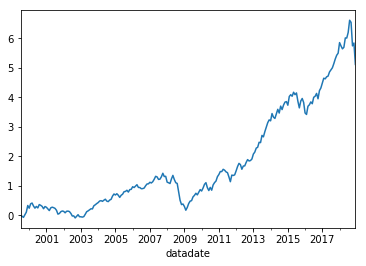

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.329763
2000-12-31   -0.025925
2001-12-31   -0.117275
2002-12-31   -0.169730
2003-12-31    0.469723
2004-12-31    0.232719
2005-12-31    0.091628
2006-12-31    0.100039
2007-12-31    0.123404
2008-12-31   -0.404831
2009-12-31    0.353497
2010-12-31    0.234773
2011-12-31    0.026590
2012-12-31    0.226986
2013-12-31    0.456574
2014-12-31    0.146338
2015-12-31   -0.005840
2016-12-31    0.101887
2017-12-31    0.221744
2018-12-31   -0.058599
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     470.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.78e-109
Time:                        06:21:41   Log-Likelihood:                 639.22
No. Observations:                 234   AIC:                            -1268.
Df Residuals:                     229   BIC:                            -1251.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.095      0.002       0.001       0.005
mktrf          1.0055      0.030     33.855      0.000       0.947       1.064
me             0.2929      0.035      8.477      0.000       0.225       0.361
ia            -0.0777      0.053     -1.480      0.140      -0.181       0.026
roe            0.1511      0.045      3.362      0.001       0.063       0.240
==============================================================================
Omnibus:                      101.895   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1348.328
Skew:                           1.308   Prob(JB):                    1.64e-293
Kurtosis:                      14.465   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     415.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          9.85e-104
Time:                        06:21:41   Log-Likelihood:                 639.22
No. Observations:                 234   AIC:                            -1268.
Df Residuals:                     229   BIC:                            -1251.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.299      0.001       0.001       0.005
mktrf          1.0055      0.041     24.576      0.000       0.925       1.086
me             0.2929      0.043      6.738      0.000       0.208       0.378
ia            -0.0777      0.147     -0.527      0.598      -0.367       0.211
roe            0.1511      0.069      2.189      0.029       0.016       0.286
==============================================================================
Omnibus:                      101.895   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1348.328
Skew:                           1.308   Prob(JB):                    1.64e-293
Kurtosis:                      14.465   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     529.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.99e-114
Time:                        06:21:41   Log-Likelihood:                 639.22
No. Observations:                 234   AIC:                            -1268.
Df Residuals:                     229   BIC:                            -1251.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.330      0.001       0.001       0.005
mktrf          1.0055      0.043     23.427      0.000       0.921       1.090
me             0.2929      0.047      6.264      0.000       0.201       0.385
ia            -0.0777      0.127     -0.612      0.541      -0.327       0.171
roe            0.1511      0.075      2.016      0.044       0.004       0.298
==============================================================================
Omnibus:                      101.895   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1348.328
Skew:                           1.308   Prob(JB):                    1.64e-293
Kurtosis:                      14.465   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     338.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.50e-103
Time:                        06:21:41   Log-Likelihood:                 628.67
No. Observations:                 234   AIC:                            -1245.
Df Residuals:                     228   BIC:                            -1225.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.294      0.001       0.002       0.006
mktrf          0.9832      0.031     31.510      0.000       0.922       1.045
smb            0.2685      0.041      6.522      0.000       0.187       0.350
hml           -0.0929      0.049     -1.914      0.057      -0.189       0.003
rmw            0.0397      0.055      0.724      0.470      -0.068       0.148
cma            0.0653      0.070      0.936      0.350      -0.072       0.203
==============================================================================
Omnibus:                       82.936   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              943.467
Skew:                           1.016   Prob(JB):                    1.34e-205
Kurtosis:                      12.625   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     374.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.20e-108
Time:                        06:21:41   Log-Likelihood:                 628.67
No. Observations:                 234   AIC:                            -1245.
Df Residuals:                     228   BIC:                            -1225.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.123      0.002       0.001       0.006
mktrf          0.9832      0.037     26.260      0.000       0.910       1.057
smb            0.2685      0.037      7.306      0.000       0.196       0.341
hml           -0.0929      0.069     -1.351      0.177      -0.228       0.042
rmw            0.0397      0.066      0.606      0.544      -0.089       0.168
cma            0.0653      0.153      0.428      0.669      -0.234       0.365
==============================================================================
Omnibus:                       82.936   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              943.467
Skew:                           1.016   Prob(JB):                    1.34e-205
Kurtosis:                      12.625   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     357.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.75e-106
Time:                        06:21:41   Log-Likelihood:                 628.67
No. Observations:                 234   AIC:                            -1245.
Df Residuals:                     228   BIC:                            -1225.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.231      0.001       0.001       0.006
mktrf          0.9832      0.040     24.321      0.000       0.904       1.062
smb            0.2685      0.036      7.546      0.000       0.199       0.338
hml           -0.0929      0.073     -1.271      0.204      -0.236       0.050
rmw            0.0397      0.060      0.660      0.509      -0.078       0.158
cma            0.0653      0.148      0.442      0.658      -0.224       0.355
==============================================================================
Omnibus:                       82.936   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              943.467
Skew:                           1.016   Prob(JB):                    1.34e-205
Kurtosis:                      12.625   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     554.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.55e-116
Time:                        06:21:42   Log-Likelihood:                 656.62
No. Observations:                 234   AIC:                            -1303.
Df Residuals:                     229   BIC:                            -1286.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.188      0.002       0.001       0.005
mktrf          1.0538      0.025     41.509      0.000       1.004       1.104
smb            0.1809      0.032      5.707      0.000       0.118       0.243
hml            0.0361      0.031      1.148      0.252      -0.026       0.098
umd            0.1704      0.021      8.248      0.000       0.130       0.211
==============================================================================
Omnibus:                       57.109   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              410.963
Skew:                           0.707   Prob(JB):                     5.76e-90
Kurtosis:                       9.336   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     418.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.41e-104
Time:                        06:21:42   Log-Likelihood:                 656.62
No. Observations:                 234   AIC:                            -1303.
Df Residuals:                     229   BIC:                            -1286.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.313      0.001       0.001       0.005
mktrf          1.0538      0.044     23.836      0.000       0.967       1.140
smb            0.1809      0.039      4.659      0.000       0.105       0.257
hml            0.0361      0.079      0.460      0.646      -0.118       0.190
umd            0.1704      0.046      3.686      0.000       0.080       0.261
==============================================================================
Omnibus:                       57.109   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              410.963
Skew:                           0.707   Prob(JB):                     5.76e-90
Kurtosis:                       9.336   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     658.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.76e-124
Time:                        06:21:42   Log-Likelihood:                 656.62
No. Observations:                 234   AIC:                            -1303.
Df Residuals:                     229   BIC:                            -1286.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.390      0.001       0.001       0.005
mktrf          1.0538      0.041     25.719      0.000       0.973       1.134
smb            0.1809      0.041      4.456      0.000       0.101       0.260
hml            0.0361      0.075      0.482      0.629      -0.111       0.183
umd            0.1704      0.047      3.641      0.000       0.079       0.262
==============================================================================
Omnibus:                       57.109   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              410.963
Skew:                           0.707   Prob(JB):                     5.76e-90
Kurtosis:                       9.336   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     199.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.62e-51
Time:                        06:21:42   Log-Likelihood:                 303.92
No. Observations:                 120   AIC:                            -597.8
Df Residuals:                     115   BIC:                            -583.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.794      0.075      -0.000       0.007
mktrf          1.0869      0.051     21.474      0.000       0.987       1.187
me             0.3155      0.050      6.310      0.000       0.216       0.414
ia            -0.0405      0.078     -0.517      0.606      -0.196       0.115
roe            0.2635      0.069      3.803      0.000       0.126       0.401
==============================================================================
Omnibus:                       61.042   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              436.297
Skew:                           1.515   Prob(JB):                     1.82e-95
Kurtosis:                      11.836   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     135.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.34e-42
Time:                        06:21:42   Log-Likelihood:                 303.92
No. Observations:                 120   AIC:                            -597.8
Df Residuals:                     115   BIC:                            -583.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.940      0.052   -3.49e-05       0.007
mktrf          1.0869      0.062     17.411      0.000       0.965       1.209
me             0.3155      0.060      5.258      0.000       0.198       0.433
ia            -0.0405      0.184     -0.220      0.826      -0.402       0.321
roe            0.2635      0.075      3.524      0.000       0.117       0.410
==============================================================================
Omnibus:                       61.042   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              436.297
Skew:                           1.515   Prob(JB):                     1.82e-95
Kurtosis:                      11.836   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     187.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.35e-49
Time:                        06:21:42   Log-Likelihood:                 303.92
No. Observations:                 120   AIC:                            -597.8
Df Residuals:                     115   BIC:                            -583.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.017      0.044    9.49e-05       0.007
mktrf          1.0869      0.060     18.034      0.000       0.969       1.205
me             0.3155      0.066      4.775      0.000       0.186       0.445
ia            -0.0405      0.156     -0.259      0.796      -0.347       0.266
roe            0.2635      0.075      3.492      0.000       0.116       0.411
==============================================================================
Omnibus:                       61.042   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              436.297
Skew:                           1.515   Prob(JB):                     1.82e-95
Kurtosis:                      11.836   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     133.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.11e-46
Time:                        06:21:42   Log-Likelihood:                 295.10
No. Observations:                 120   AIC:                            -578.2
Df Residuals:                     114   BIC:                            -561.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.002      2.158      0.033       0.000       0.009
mktrf          1.0641      0.058     18.443      0.000       0.950       1.178
smb            0.2961      0.065      4.531      0.000       0.167       0.426
hml           -0.1830      0.080     -2.286      0.024      -0.342      -0.024
rmw            0.1594      0.094      1.688      0.094      -0.028       0.346
cma            0.1915      0.103      1.851      0.067      -0.013       0.396
==============================================================================
Omnibus:                       39.047   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.426
Skew:                           0.932   Prob(JB):                     1.11e-44
Kurtosis:                       9.084   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     162.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.95e-50
Time:                        06:21:42   Log-Likelihood:                 295.10
No. Observations:                 120   AIC:                            -578.2
Df Residuals:                     114   BIC:                            -561.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.002      2.122      0.034       0.000       0.009
mktrf          1.0641      0.069     15.518      0.000       0.930       1.198
smb            0.2961      0.050      5.926      0.000       0.198       0.394
hml           -0.1830      0.107     -1.716      0.086      -0.392       0.026
rmw            0.1594      0.086      1.854      0.064      -0.009       0.328
cma            0.1915      0.183      1.047      0.295      -0.167       0.550
==============================================================================
Omnibus:                       39.047   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.426
Skew:                           0.932   Prob(JB):                     1.11e-44
Kurtosis:                       9.084   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     152.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.60e-49
Time:                        06:21:42   Log-Likelihood:                 295.10
No. Observations:                 120   AIC:                            -578.2
Df Residuals:                     114   BIC:                            -561.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0045      0.002      2.226      0.026       0.001       0.008
mktrf          1.0641      0.072     14.755      0.000       0.923       1.205
smb            0.2961      0.043      6.946      0.000       0.213       0.380
hml           -0.1830      0.115     -1.598      0.110      -0.407       0.041
rmw            0.1594      0.079      2.012      0.044       0.004       0.315
cma            0.1915      0.175      1.095      0.274      -0.151       0.534
==============================================================================
Omnibus:                       39.047   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.426
Skew:                           0.932   Prob(JB):                     1.11e-44
Kurtosis:                       9.084   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     239.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.94e-55
Time:                        06:21:42   Log-Likelihood:                 313.52
No. Observations:                 120   AIC:                            -617.0
Df Residuals:                     115   BIC:                            -603.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      3.095      0.002       0.002       0.009
mktrf          1.1217      0.041     27.251      0.000       1.040       1.203
smb            0.1376      0.047      2.935      0.004       0.045       0.230
hml            0.0469      0.047      0.998      0.320      -0.046       0.140
umd            0.2071      0.029      7.155      0.000       0.150       0.264
==============================================================================
Omnibus:                       20.788   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.197
Skew:                           0.481   Prob(JB):                     5.71e-16
Kurtosis:                       6.621   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     234.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.71e-54
Time:                        06:21:42   Log-Likelihood:                 313.52
No. Observations:                 120   AIC:                            -617.0
Df Residuals:                     115   BIC:                            -603.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.002      3.449      0.001       0.002       0.008
mktrf          1.1217      0.062     18.142      0.000       1.001       1.243
smb            0.1376      0.048      2.843      0.004       0.043       0.232
hml            0.0469      0.097      0.481      0.631      -0.144       0.238
umd            0.2071      0.052      3.964      0.000       0.105       0.309
==============================================================================
Omnibus:                       20.788   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.197
Skew:                           0.481   Prob(JB):                     5.71e-16
Kurtosis:                       6.621   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     473.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.03e-70
Time:                        06:21:42   Log-Likelihood:                 313.52
No. Observations:                 120   AIC:                            -617.0
Df Residuals:                     115   BIC:                            -603.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.001      3.550      0.000       0.002       0.008
mktrf          1.1217      0.050     22.286      0.000       1.023       1.220
smb            0.1376      0.048      2.892      0.004       0.044       0.231
hml            0.0469      0.094      0.500      0.617      -0.137       0.231
umd            0.2071      0.046      4.464      0.000       0.116       0.298
==============================================================================
Omnibus:                       20.788   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.197
Skew:                           0.481   Prob(JB):                     5.71e-16
Kurtosis:                       6.621   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     498.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.50e-69
Time:                        06:21:42   Log-Likelihood:                 374.96
No. Observations:                 114   AIC:                            -739.9
Df Residuals:                     109   BIC:                            -726.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      4.228      0.000       0.002       0.006
mktrf          0.9399      0.027     34.647      0.000       0.886       0.994
me             0.2541      0.042      6.068      0.000       0.171       0.337
ia            -0.2362      0.058     -4.065      0.000      -0.351      -0.121
roe           -0.1144      0.051     -2.241      0.027      -0.216      -0.013
==============================================================================
Omnibus:                        0.757   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.685   Jarque-Bera (JB):                0.650
Skew:                          -0.184   Prob(JB):                        0.722
Kurtosis:                       2.963   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     353.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.13e-61
Time:                        06:21:42   Log-Likelihood:                 374.96
No. Observations:                 114   AIC:                            -739.9
Df Residuals:                     109   BIC:                            -726.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.593      0.000       0.002       0.006
mktrf          0.9399      0.029     32.161      0.000       0.883       0.997
me             0.2541      0.052      4.910      0.000       0.153       0.356
ia            -0.2362      0.068     -3.474      0.001      -0.369      -0.103
roe           -0.1144      0.068     -1.691      0.091      -0.247       0.018
==============================================================================
Omnibus:                        0.757   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.685   Jarque-Bera (JB):                0.650
Skew:                          -0.184   Prob(JB):                        0.722
Kurtosis:                       2.963   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     517.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.71e-70
Time:                        06:21:42   Log-Likelihood:                 374.96
No. Observations:                 114   AIC:                            -739.9
Df Residuals:                     109   BIC:                            -726.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.152      0.002       0.001       0.006
mktrf          0.9399      0.027     35.273      0.000       0.888       0.992
me             0.2541      0.049      5.157      0.000       0.158       0.351
ia            -0.2362      0.075     -3.160      0.002      -0.383      -0.090
roe           -0.1144      0.065     -1.753      0.080      -0.242       0.013
==============================================================================
Omnibus:                        0.757   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.685   Jarque-Bera (JB):                0.650
Skew:                          -0.184   Prob(JB):                        0.722
Kurtosis:                       2.963   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     524.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.94e-74
Time:                        06:21:42   Log-Likelihood:                 390.38
No. Observations:                 114   AIC:                            -768.8
Df Residuals:                     108   BIC:                            -752.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.807      0.000       0.001       0.005
mktrf          0.9500      0.023     41.845      0.000       0.905       0.995
smb            0.2119      0.037      5.750      0.000       0.139       0.285
hml           -0.0362      0.047     -0.770      0.443      -0.129       0.057
rmw           -0.2412      0.058     -4.191      0.000      -0.355      -0.127
cma           -0.2214      0.073     -3.031      0.003      -0.366      -0.077
==============================================================================
Omnibus:                        0.501   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.778   Jarque-Bera (JB):                0.270
Skew:                          -0.112   Prob(JB):                        0.874
Kurtosis:                       3.079   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     375.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.52e-66
Time:                        06:21:42   Log-Likelihood:                 390.38
No. Observations:                 114   AIC:                            -768.8
Df Residuals:                     108   BIC:                            -752.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.366      0.001       0.001       0.005
mktrf          0.9500      0.029     33.037      0.000       0.894       1.006
smb            0.2119      0.038      5.635      0.000       0.138       0.286
hml           -0.0362      0.039     -0.934      0.350      -0.112       0.040
rmw           -0.2412      0.043     -5.589      0.000      -0.326      -0.157
cma           -0.2214      0.074     -3.004      0.003      -0.366      -0.077
==============================================================================
Omnibus:                        0.501   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.778   Jarque-Bera (JB):                0.270
Skew:                          -0.112   Prob(JB):                        0.874
Kurtosis:                       3.079   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     546.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.98e-75
Time:                        06:21:42   Log-Likelihood:                 390.38
No. Observations:                 114   AIC:                            -768.8
Df Residuals:                     108   BIC:                            -752.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.821      0.005       0.001       0.005
mktrf          0.9500      0.029     32.501      0.000       0.893       1.007
smb            0.2119      0.035      6.107      0.000       0.144       0.280
hml           -0.0362      0.039     -0.937      0.349      -0.112       0.040
rmw           -0.2412      0.037     -6.463      0.000      -0.314      -0.168
cma           -0.2214      0.077     -2.869      0.004      -0.373      -0.070
==============================================================================
Omnibus:                        0.501   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.778   Jarque-Bera (JB):                0.270
Skew:                          -0.112   Prob(JB):                        0.874
Kurtosis:                       3.079   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     534.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.31e-70
Time:                        06:21:42   Log-Likelihood:                 378.66
No. Observations:                 114   AIC:                            -747.3
Df Residuals:                     109   BIC:                            -733.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.246      0.027       0.000       0.004
mktrf          0.9841      0.025     39.545      0.000       0.935       1.033
smb            0.2602      0.039      6.705      0.000       0.183       0.337
hml           -0.0474      0.040     -1.187      0.238      -0.127       0.032
umd            0.0671      0.030      2.227      0.028       0.007       0.127
==============================================================================
Omnibus:                        0.582   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.748   Jarque-Bera (JB):                0.349
Skew:                          -0.130   Prob(JB):                        0.840
Kurtosis:                       3.074   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     413.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.11e-65
Time:                        06:21:42   Log-Likelihood:                 378.66
No. Observations:                 114   AIC:                            -747.3
Df Residuals:                     109   BIC:                            -733.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      2.118      0.034       0.000       0.004
mktrf          0.9841      0.026     38.271      0.000       0.934       1.035
smb            0.2602      0.040      6.484      0.000       0.182       0.339
hml           -0.0474      0.039     -1.212      0.225      -0.124       0.029
umd            0.0671      0.024      2.801      0.005       0.020       0.114
==============================================================================
Omnibus:                        0.582   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.748   Jarque-Bera (JB):                0.349
Skew:                          -0.130   Prob(JB):                        0.840
Kurtosis:                       3.074   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     573.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.30e-72
Time:                        06:21:42   Log-Likelihood:                 378.66
No. Observations:                 114   AIC:                            -747.3
Df Residuals:                     109   BIC:                            -733.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      1.899      0.058   -6.35e-05       0.004
mktrf          0.9841      0.025     39.625      0.000       0.935       1.033
smb            0.2602      0.042      6.157      0.000       0.177       0.343
hml           -0.0474      0.037     -1.288      0.198      -0.120       0.025
umd            0.0671      0.027      2.497      0.013       0.014       0.120
==============================================================================
Omnibus:                        0.582   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.748   Jarque-Bera (JB):                0.349
Skew:                          -0.130   Prob(JB):                        0.840
Kurtosis:                       3.074   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""